In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import random

Quantum Circuit:


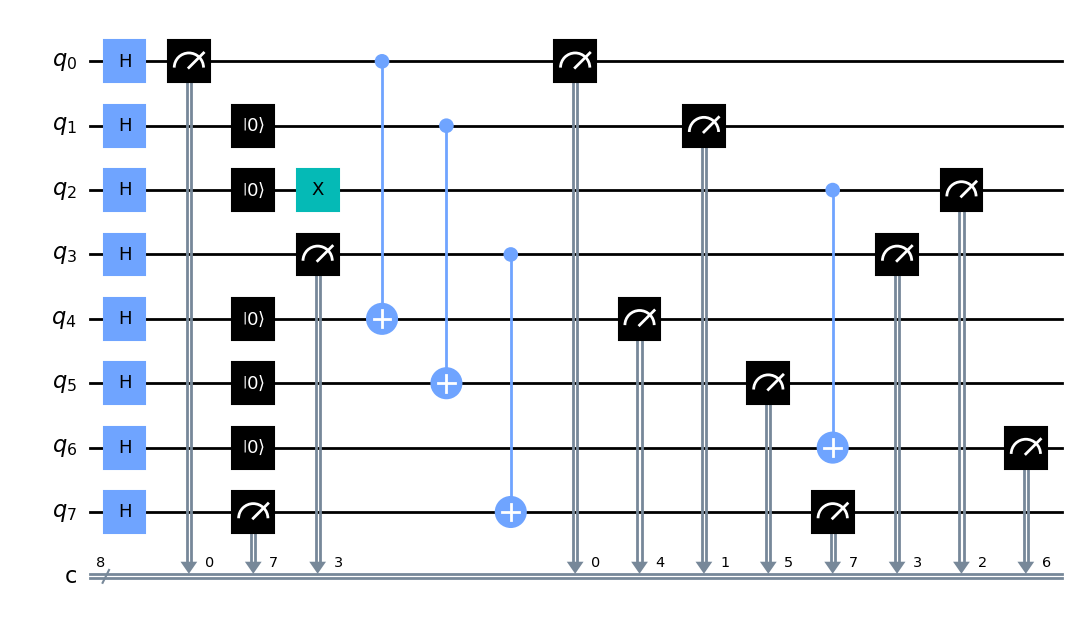

Alice operations: ['SIFT', 'CTRL', 'CTRL', 'SIFT']
Bob operations  : ['CTRL', 'CTRL', 'CTRL', 'SIFT']
Bell measurement results (TP):
Position: 0 Bell result: 0
Position: 3 Bell result: 0
Alice's final measurement result: 1101
Bob's final measurement result  : 1101
Presence of Eavesdropper : False
Alice's raw key  : 11
Bob's derived key: 11


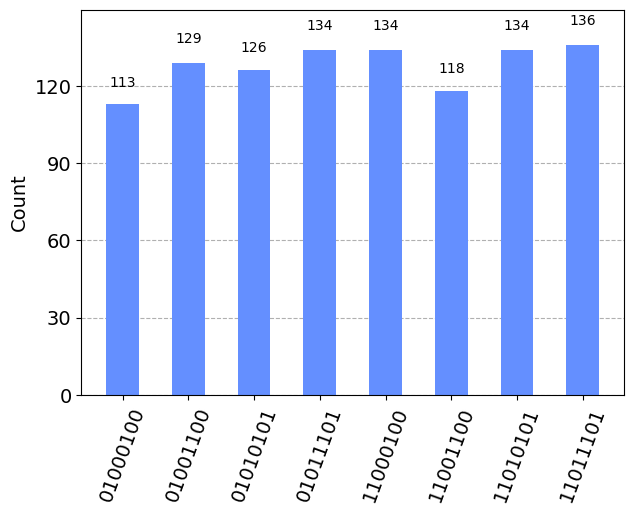

In [3]:
# Specify the number of qubits prepared by (TP) for Alice and bob
num_qubits = 4

# Initialize quantum circuit with 2*num_qubits qubits (for Alice and Bob)
qc = QuantumCircuit(2*num_qubits, 2*num_qubits)

# Apply Hadamard gate to each qubit to initialize them in the plus state
for i in range(2*num_qubits):
    qc.h(i)

# Lists to store the positions where SIFT operations were performed by Alice
alice_sift_positions = []
bob_sift_positions = []
recorded_positions = []

# Dictionary to store Bob's operations for each qubit pair
bob_info = {}

# Dictionary to store Alice's operations for each qubit pair
alice_info = {}


#Dictionary to store Alice and Bob operations    
alice_oper = []
bob_oper = []

# function to perform check for bell measurement result
def determine_bell_result(alice_measurement, bob_measurement):
    if alice_measurement == bob_measurement:
        return '0'  # Φ+
    else:
        return '1'  # Ψ+
    
# function to derive bob key from the bell result 
def determine_bob_key(bob_measurement_result , bell_result):
    if bell_result == '1':
        if bob_measurement_result == '0':
            return '1'
        else: 
            return '0'
    else:
        return bob_measurement_result 

# function to perform check for eavesdropping ...
def check_eve(alice_measurement_result, bob_measurement_result, bell_result):
    for tp, alice, bob in zip(bell_result, alice_measurement_result, bob_measurement_result):
        if (alice == bob and tp != 0) or (alice != bob and tp != 1):
            return False  # Inconsistent results, possible eavesdropping
    return True


# Apply random operation for Alice and Bob
for i in range(num_qubits):
    # Randomly decide whether to apply SIFT operation or not for Alice
    if random.choice([True, False]):
        alice_sift_positions.append(i)
        alice_oper.append('SIFT')
        qc.measure(i, i)  # Measure the qubit
    else:
        qc.reset(i)  # Discard the qubit
        alice_oper.append('CTRL')
        random_bit = random.randint(0, 1)  # Randomly choose 0 or 1
        if random_bit == 1:
            qc.x(i)  # Prepare qubit as |1⟩

    # Randomly decide whether to apply SIFT operation or not for Bob
    if random.choice([True, False]):
        bob_sift_positions.append(i)
        bob_oper.append('SIFT')
        qc.measure(i+num_qubits, i+num_qubits)  # Measure the qubit
    else:
        qc.reset(i+num_qubits)
        bob_oper.append('CTRL')# Discard the qubit
        random_bit = random.randint(0, 1)  # Randomly choose 0 or 1
        if random_bit == 1:
            qc.x(i+num_qubits)  # Prepare qubit as |1⟩

    # Store Alice's and Bob's operations for this qubit pair
    alice_info[i] = {'operation': alice_oper}
    bob_info[i] = {'operation': bob_oper}

    
# Perform Bell state measurements by TP
for i in range(num_qubits):
    # Apply CNOT gate between qubits from Alice and Bob
    qc.cx(i, i+num_qubits)
    # Measure both qubits in the Z basis
    qc.measure([i, i+num_qubits], [i, i+num_qubits])

# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
result = simulator.run(compiled_circuit).result()

# Get the measurement outcomes
counts = result.get_counts()


# Visualize the quantum circuit
print("Quantum Circuit:")
display(qc.draw(output='mpl', style ='Clifford', fold = 40))


#print ALice and Bob operations 
print("Alice operations:",alice_oper)
print("Bob operations  :",bob_oper)

# Derive Alice and bob measurement outcomes 
alice_measurement_outcomes = [outcome[:num_qubits] for outcome in counts.keys()]
bob_measurement_outcomes = [outcome[num_qubits:] for outcome in counts.keys()]

# Extract Alice's and Bob's measurement results from the most frequent outcome
alice_final_result = counts.most_frequent()[:num_qubits]
bob_final_result = counts.most_frequent()[num_qubits:]

# Extract Alice's raw key based on her measurement results
alice_raw_key = ''.join([alice_final_result[i] for i in alice_sift_positions])


# Determine Bob's derived key based on Alice's SIFT positions, Bell measurement results, and Bob's measurements
bob_derived_key = ''
for position in alice_sift_positions:
    alice_measurement_result = alice_final_result[position]
    bob_measurement_result = bob_final_result[position]

    # Determine the Bell measurement result based on Alice's and Bob's measurement outcomes
    bell_result = determine_bell_result(alice_measurement_result, bob_measurement_result)

    if bell_result == '0':
        # If the Bell result is '0', Bob's derived key is his measurement outcome
        bob_derived_key += bob_measurement_result
    else:
        # If the Bell result is '1', Bob's derived key is the complement of his measurement outcome
        bob_derived_key += '0' if bob_measurement_result == '1' else '1'


# Print Bell measurement results announced by TP
print("Bell measurement results (TP):")
for position in alice_sift_positions:
    # Convert Alice's position to Bob's position (offset by num_qubits)
    bob_position = position + num_qubits

    # Get Alice's and Bob's measurement outcomes for this qubit pair
    alice_measurement_result = counts.most_frequent()[position]
    bob_measurement_result = counts.most_frequent()[bob_position]

    # Determine the Bell measurement result based on Alice's and Bob's measurement outcomes
    bell_result = determine_bell_result(alice_measurement_result, bob_measurement_result)

    print("Position:", position, "Bell result:", bell_result)

# Display Alice's and Bob's measurement results
print("Alice's final measurement result:", alice_final_result)
print("Bob's final measurement result  :", bob_final_result)
    
    


#checking for eavesdropper...
print("Presence of Eavesdropper :",check_eve(alice_measurement_result, bob_measurement_result, bell_result))
    
# Printing raw key bits...
print("Alice's raw key  :", alice_raw_key)
# Print Bob's derived key
print("Bob's derived key:", bob_derived_key)



# Calculate counts for the derived keys
bob_derived_counts = {}
for key in bob_derived_key:
    bob_derived_counts[key] = bob_derived_key.count(key)

# Plot the histogram
plot_histogram(counts)


In [ ]:
plot_histogram(bob_derived_counts)